<a href="https://colab.research.google.com/github/angeline2422/kaggle/blob/main/ensemble_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/a.zip"


Archive:  /content/drive/MyDrive/a.zip
replace Alzheimer_s Dataset/test/MildDemented/26 (19).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
print("TensorFlow Version:", tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version: 2.14.0


**DATA AUGMENTATION**

In [4]:
import os
from distutils.dir_util import copy_tree
from distutils.dir_util import remove_tree
base_dir = "/content/Alzheimer_s Dataset"
test_dir = '/content/Alzheimer_s Dataset/test'
train_dir = '/content/Alzheimer_s Dataset/train'
work_dir = '/content/Alzheimer_s Dataset/working'
if os.path.exists(work_dir):
  remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['NonDemented', 'MildDemented', 'VeryMildDemented', 'ModerateDemented']


In [5]:
import os
from distutils.dir_util import copy_tree
from distutils.dir_util import remove_tree
WORK_DIR = '/content/Alzheimer_s Dataset'
CLASSES = [
'NonDemented',
'VeryMildDemented',
'MildDemented',
'ModerateDemented'
]
IMG_SIZE = 150
IMAGE_SIZE = [IMG_SIZE, IMG_SIZE]
DIM = (IMG_SIZE, IMG_SIZE)
# Construct the train and test directories using WORK_DIR and CLASSES
train_dir = os.path.join(WORK_DIR, "train")
test_dir = os.path.join(WORK_DIR, "test")
# Create a working directory within WORK_DIR
work_dir = os.path.join(WORK_DIR, "working")
if os.path.exists(work_dir):
  remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['NonDemented', 'MildDemented', 'VeryMildDemented', 'ModerateDemented']


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
# Define the ImageDataGenerator with augmentation parameters
image_data_generator = ImageDataGenerator(
rescale=1.0 / 255,
brightness_range=BRIGHT_RANGE,
zoom_range=ZOOM,
data_format=DATA_FORMAT,
fill_mode=FILL_MODE,
horizontal_flip=HORZ_FLIP
)
# Create a generator for the training data from the working directory
train_data_gen = image_data_generator.flow_from_directory(
directory=work_dir,
target_size=IMAGE_SIZE,
batch_size=6500
                                                           ,
shuffle=False
)


Found 6400 images belonging to 4 classes.


In [7]:
def show_images(generator,y_pred=None):

# get image lables
  labels =dict(zip([0,1,2,3], CLASSES))
  # get a batch of images
  x,y = generator.next()
  # display a grid of 9 images
  plt.figure(figsize=(10, 10))
  if y_pred is None:
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      idx = randint(0, 6400)
      plt.imshow(x[idx])
      plt.axis("off")
      plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
  else:
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(x[i])
      plt.axis("off")
      plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

In [13]:
import matplotlib.pyplot as plt

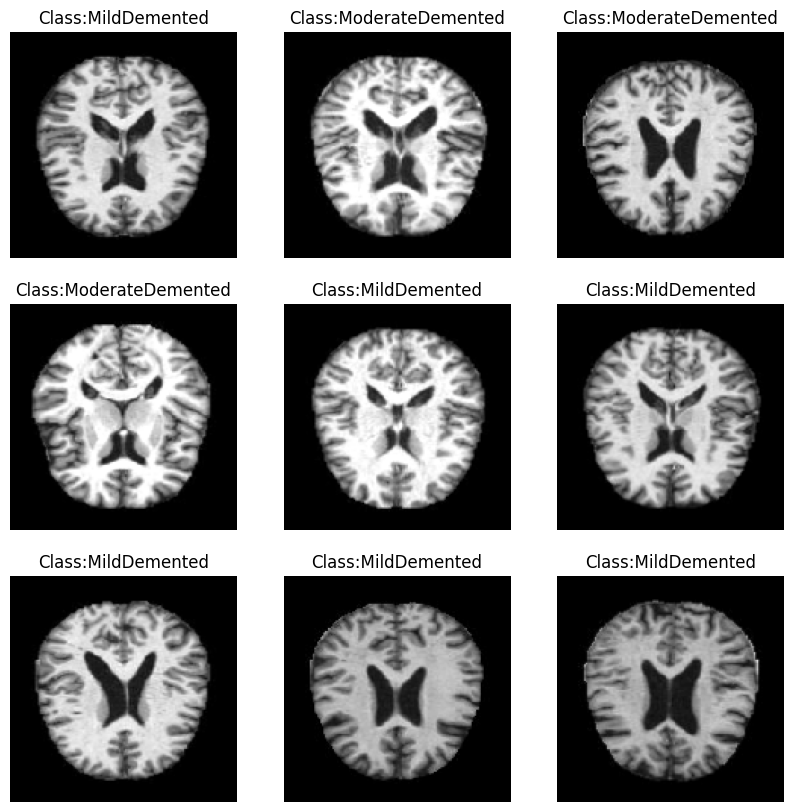

In [14]:
show_images(train_data_gen)

In [8]:
#Retrieving the data from the ImageDataGenerator iterator
#ImageDataGenerator iterator üzerinden veri alma
train_data, train_labels = train_data_gen.next()

In [9]:
#Getting to know the dimensions of our dataset
#Veri setimizdeki boyutları öğrenme
print(train_data.shape, train_labels.shape)

(6400, 150, 150, 3) (6400, 4)


In [10]:
#Splitting the data into train, test, and validation sets
#Veriyi train, test ve validation olarak ayıralım
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import DenseNet121, InceptionV3, InceptionResNetV2

def deep_feature_concatenation():
    # Input Layer
    input_layer = Input(shape=(150, 150, 3))

    # Pre-trained Models Layers
    dense_net = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_layer)
    inception_v3 = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)
    inception_resnet_v2 = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)

    # Pre-trained Models Features
    dense_net_features = GlobalAveragePooling2D()(dense_net.output)
    inception_v3_features = GlobalAveragePooling2D()(inception_v3.output)
    inception_resnet_v2_features = GlobalAveragePooling2D()(inception_resnet_v2.output)

    # Concatenate features from different models
    features = concatenate([dense_net_features, inception_v3_features, inception_resnet_v2_features])

    # Flatten concatenated features
    features = Flatten()(features)

    # MLP for Classification
    x = Dense(1024, activation='relu')(features)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    '''x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)'''

    # Output Layer
    output_layer = Dense(4, activation='softmax')(x)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Build the Model
model = deep_feature_concatenation()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94[0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(train_data, train_labels, epochs=20, batch_size=6500, validation_data=(val_data, val_labels))


# Make predictions on the testing data
#y_pred = model.predict(X_test)

Epoch 1/20


**Inception**

In [ ]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [ ]:
for layer in inception_model.layers:
  layer.trainable=False

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling3D
from tensorflow.keras.models import Model
# Load the provided Inception V3 model with custom input shape
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")
for layer in inception_model.layers:
  layer.trainable = False
# Create a new model using the features extracted by Inception V3
feature_extractor1_model_1= Model(inputs=inception_model.input, outputs=GlobalAveragePooling2D()(inception_model.output))
# Optionally, you can set the layers of the feature extractor to be non-trainable
for layer in feature_extractor1_model_1.layers:
  layer.trainable = False

In [ ]:
num_features = feature_extractor1_model_1.output.shape[-1]
print("Number of Features Extracted:", num_features)

Number of Features Extracted: 2048


**Dense Net**

In [ ]:
def conv_block(filters, act='relu'):

  block = Sequential()
  block.add(Conv2D(filters, 3, activation=act, padding='same'))
  block.add(Conv2D(filters, 3, activation=act, padding='same'))
  block.add(BatchNormalization())
  block.add(MaxPool2D())
  return block
def dense_block(units, dropout_rate, act='relu'):

  block = Sequential()
  block.add(Dense(units, activation=act))
  block.add(BatchNormalization())
  block.add(Dropout(dropout_rate))
  return block


In [ ]:
def construct_model(act='relu'):
  """Constructing a Sequential CNN architecture for performing the classification task. """
  model = Sequential([
  Input(shape=(*IMAGE_SIZE, 3)),
  Conv2D(16, 3, activation=act, padding='same'),
  Conv2D(16, 3, activation=act, padding='same'),
  MaxPool2D(),
  conv_block(32),
  conv_block(64),
  conv_block(128),
  Dropout(0.5),
  conv_block(256),
  Dropout(0.5),
  Flatten(),
  dense_block(128, 0.7),
  dense_block(128, 0.5),
  dense_block(64, 0.3),
  Dense(4, activation='softmax')
  ], name = "cnn_model")
  return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_acc') > 0.99:
      print("\nReached accuracy threshold! Terminating training.")
      self.model.stop_training = True
my_callback = MyCallback()
#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
# Load a pre-trained DenseNet model
densenet_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
# Create a new model using the features extracted by DenseNet
feature_extractor_model_2 = Model(inputs=densenet_model.input, outputs=GlobalAveragePooling2D()(densenet_model.output))
# Optionally, you can set the layers of the feature extractor to be non-trainable
for layer in feature_extractor_model_2.layers:
  layer.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
num_features = feature_extractor_model_2.output.shape[-1]
print("Number of Features Extracted:", num_features)

Number of Features Extracted: 1024


**Inception ResNEtV2**

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
# Load the Inception-ResNet-V2 model
inception_resnet_model = InceptionResNetV2(input_shape=(176, 176, 3), include_top=False, weights=None)
# Freeze the layers
for layer in inception_resnet_model.layers:
  layer.trainable = False


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Load a pre-trained Inception ResNetV2 model
inception_resnetv2_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
# Create a new model using the features extracted by Inception ResNetV2
feature_extractor_model_3 = Model(inputs=inception_resnetv2_model.input, outputs=GlobalAveragePooling2D()(inception_resnetv2_model.output))
# Optionally, you can set the layers of the feature extractor to be non-trainable
for layer in feature_extractor_model_3.layers:
  layer.trainable = False

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
num_features = feature_extractor_model_3.output.shape[-1]
print("Number of Features Extracted:", num_features)


Number of Features Extracted: 1536


In [ ]:
feature_extractor_model_3.summary()


In [ ]:
print(feature_extractor_model_3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load a pre-trained ResNet50 model
resnet50_model = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))

# Create a new model using the features extracted by ResNet50
feature_extractor_model_4 = Model(inputs=resnet50_model.input, outputs=GlobalAveragePooling2D()(resnet50_model.output))

# Optionally, you can set the layers of the feature extractor to be non-trainable
for layer in feature_extractor_model_4.layers:
    layer.trainable = False


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
num_features = feature_extractor_model_4.output.shape[-1]
print("Number of Features Extracted:", num_features)


Number of Features Extracted: 2048


**Meta Ensemble Learning**

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Define the number of classes in your classification task
num_classes = 4 # Replace with the actual number of classes
# Define a shared input layer
input_layer = Input(shape=(*IMAGE_SIZE, 3))
# Connect each feature extractor model to the shared input
features1 = feature_extractor1_model_1(input_layer)
features2 = feature_extractor_model_2(input_layer)
#features3 = feature_extractor_model_3(input_layer)
features4 = feature_extractor_model_4(input_layer)
# Concatenate the extracted features
concatenated_features = Concatenate()([features1, features2, features4])
# Add additional layers for the meta-ensemble model
x = Dense(512, activation='relu')(concatenated_features)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
# Compile the model with your choice of optimizer and loss
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
meta_ensemble_model.summary

In [ ]:
from keras.utils import plot_model

# After creating the model as you've shown
plot_model(meta_ensemble_model, to_file='model_graph.png', show_shapes=True, show_layer_names=False)

In [ ]:
epochs = 20  # Replace with the desired number of epochs
history = model.fit(train_data, train_labels, epochs=epochs, batch_size=6500, validation_data=(val_data, val_labels))


Epoch 1/20


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define the input shape for the Siamese network
input_shape = (*IMAGE_SIZE, 3)

# Define the base Siamese CNN model
def create_siamese_base(input_shape, name):
    model_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', name=name+'_conv1')(model_input)
    x = MaxPooling2D(name=name+'_pool1')(x)
    x = Conv2D(128, (3, 3), activation='relu', name=name+'_conv2')(x)
    x = MaxPooling2D(name=name+'_pool2')(x)
    x = Conv2D(256, (3, 3), activation='relu', name=name+'_conv3')(x)
    x = GlobalAveragePooling2D(name=name+'_avg_pool')(x)
    model = Model(model_input, x, name=name)
    return model

# Create two instances of the base Siamese CNN model with unique names
siamese_base1 = create_siamese_base(input_shape, 'siamese_base1')
siamese_base2 = create_siamese_base(input_shape, 'siamese_base2')

# Define the inputs for the Siamese network
input_1 = Input(shape=input_shape, name='input_1')
input_2 = Input(shape=input_shape, name='input_2')

# Extract features using the base Siamese CNN model
output_1 = siamese_base1(input_1)
output_2 = siamese_base2(input_2)

# Optionally, you can set the layers of the feature extractor to be non-trainable
for layer in siamese_base1.layers:
    layer.trainable = False
for layer in siamese_base2.layers:
    layer.trainable = False

# Create the Siamese feature extraction model
feature_extractor_model_4 = Model(inputs=[input_1, input_2], outputs=[output_1, output_2])

# Compile the feature extraction model with your choice of optimizer and loss (if needed)
# feature_extractor_model.compile(optimizer='adam', loss='your_loss_function')

# You can use this feature_extractor_model for feature extraction in Siamese tasks


In [ ]:
import numpy as np

# Assuming siamese_base1 and siamese_base2 are the models in the list
feature_extractor_model_4 = [siamese_base1, siamese_base2]

# Convert the list of models to a NumPy array
feature_extractor_array = np.array(feature_extractor_model_4)

# Now, you have feature_extractor_array as a NumPy array containing your models


In [ ]:
num_features = feature_extractor_array.shape[-1]
print("Number of Features Extracted:", num_features)

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Attention
from tensorflow.keras.models import Model

# Define the number of classes in your classification task
num_classes = 4  # Replace with the actual number of classes

# Define a shared input layer
input_layer = Input(shape=(51200,))

# Split the features from each feature extractor
features1, features2, features3 = input_layer[:, :51200 // 3], input_layer[:, 51200 // 3: 2 * 51200 // 3], input_layer[:, 2 * 51200 // 3:]

# Apply attention mechanism to extracted features
attention1 = Attention()([features1, features2])
attention2 = Attention()([features1, features3])
attention3 = Attention()([features2, features3])

# Concatenate the attended features
concatenated_features = Concatenate()([attention1, attention2, attention3])

# Add additional layers for the attention-based ensemble model
x = Dense(512, activation='relu')(concatenated_features)
x = Dense(256, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the attention-based ensemble model
attention_ensemble_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with your choice of optimizer and loss
attention_ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

def create_feature_extractor_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    # Add more layers as needed for your specific feature extraction task
    return model

input_shape = (176, 176, 2048)  # Adjust the input shape to match your needs
feature_extractor_model_1 = create_feature_extractor_model(input_shape)
feature_extractor_model_2 = create_feature_extractor_model(input_shape)
feature_extractor_model_3 = create_feature_extractor_model(input_shape)

# Now, you can use these modified feature extractor models in your ensemble architecture.


In [ ]:
common_dense = Dense(2048)(input_layer)  # Adjust the dimension as needed
features1 = feature_extractor_model_1(common_dense)
features2 = feature_extractor_model_2(common_dense)
features3 = feature_extractor_model_3(common_dense)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with augmentation parameters
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_data_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    brightness_range=BRIGHT_RANGE,
    zoom_range=ZOOM,
    data_format=DATA_FORMAT,
    fill_mode=FILL_MODE,
    horizontal_flip=HORZ_FLIP
)

# Load and preprocess a subset of images from your dataset
# You need to specify the directory for the subset of images
subset_directory = 'path_to_subset_directory'  # Replace with the actual directory

subset_data_gen = image_data_generator.flow_from_directory(
    directory=subset_directory,
    target_size=IMAGE_SIZE,
    batch_size=300,  # Set this to the number of images in your subset
    shuffle=False  # No need to shuffle for feature visualization
)

# Create a feature extractor model
# Replace 'feature_extractor_model_3' and 'layer_name' with your specific model and layer
layer_name = 'conv2d_602'
feature_extractor_model = Model(inputs=feature_extractor_model_3.input, outputs=feature_extractor_model_3.get_layer(layer_name).output)

# Iterate through the subset of images and visualize feature maps
for i in range(len(subset_data_gen)):
    batch_images, _ = subset_data_gen[i]
    feature_maps = feature_extractor_model.predict(batch_images)

    for j in range(feature_maps.shape[0]):
        # Visualize feature maps for each image in the batch
        plot_feature_maps(feature_maps[j])


In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the number of classes in your classification task
num_classes = 4  # Replace with the actual number of classes

# Define a shared input layer
input_layer = Input(shape=(*IMAGE_SIZE, 3))

# Connect each feature extractor model to the shared input
features1 = feature_extractor_model_1(input_layer)
features2 = feature_extractor_model_2(input_layer)
features3 = feature_extractor_model_3(input_layer)

# Apply attention mechanism to extracted features
attention1 = Attention(use_scale=True)([features1, features2])
attention2 = Attention(use_scale=True)([features1, features3])
attention3 = Attention(use_scale=True)([features2, features3])

# Concatenate the attended features
concatenated_features = Concatenate()([attention1, attention2, attention3])

# Add additional layers for the attention-based ensemble model
x = Dense(512, activation='relu')(concatenated_features)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the attention-based ensemble model
attention_ensemble_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with your choice of optimizer and loss
attention_ensemble_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming you have test_data as your test dataset

# Generate predictions for each feature extractor model
feature_extractor1_predictions = feature_extractor_model_1.predict(test_data)
feature_extractor2_predictions = feature_extractor_model_2.predict(test_data)
feature_extractor3_predictions = feature_extractor_model_3.predict(test_data)

# Combine the predictions into a list
all_predictions = [feature_extractor1_predictions, feature_extractor2_predictions, feature_extractor3_predictions]

# Create an empty list to store the majority voting predictions
majority_voting_predictions = []

# Iterate through each sample in your dataset
for sample_predictions in zip(*all_predictions):
    # Count the occurrences of each class label in the predictions
    class_counts = {class_label: list(sample_predictions).count(class_label) for class_label in np.array(sample_predictions).tolist()}


    # Find the class label with the maximum count (majority vote)
    majority_vote = max(class_counts, key=class_counts.get)

    # Append the majority vote to the list of majority voting predictions
    majority_voting_predictions.append(majority_vote)

# Assuming true_labels contains the true labels for your test data
# Calculate the accuracy of the majority voting ensemble
accuracy = accuracy_score(true_labels, majority_voting_predictions)

print(f"Majority Voting Ensemble Accuracy: {accuracy}")


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

# Assuming you have extracted features using your feature extractor models
features1 = feature_extractor_model_1  # Modify as needed
features2 = feature_extractor_model_2  # Modify as needed
features3 = feature_extractor_model_3  # Modify as needed

# Check if any of the feature extraction models returned None
if any(x is None for x in [features1, features2, features3]):
    raise ValueError("One of the feature extractor models did not return features. Check the model configurations.")

# Create an input layer for the extracted features
input_layer = Concatenate()([features1, features2, features3])

# Define dilation rates for the pyramid
dilation_rates = [1, 2, 4]

# Create pyramid dilated convolutions
pyramid_dilated_features = []
for rate in dilation_rates:
    x = Conv2D(64, (3, 3), padding='same', dilation_rate=(rate, rate), activation='relu')(input_layer)
    pyramid_dilated_features.append(x)

# Concatenate the pyramid dilated features
concatenated_features = pyramid_dilated_features[0]  # Start with the first feature map
if len(pyramid_dilated_features) > 1:
    concatenated_features = Concatenate()(pyramid_dilated_features)

# Add more convolutional layers or other operations as needed

# Create the model
model = Model(inputs=[features1, features2, features3], outputs=concatenated_features)

# Compile the model with an optimizer, loss, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

